In [2]:
from skimage import io, img_as_ubyte
from skimage.morphology import white_tophat, disk
from skimage.filters import gaussian
import numpy as np
import os
import matplotlib.pyplot as plt

In [3]:
# filenames are structured with '_w1', '_w2', '_w3' to indicate channels.
directory = '/Users/elizabeth 1/Library/CloudStorage/Box-Box/Wu Lab/Project - 2024/Functional screening/240411 test in 6-well/Moe Effciency_Plate_1252/TimePoint_1'
output_directory = '/Users/elizabeth 1/Library/CloudStorage/Box-Box/Wu Lab/Project - 2024/Functional screening/240411 test in 6-well/Moe Effciency_Plate_1252/color composite_Elizabeth'

In [4]:
# Create lists for different wavelength images
w1_images, w2_images = [], []

# Populate the lists with corresponding image filenames
for filename in sorted(os.listdir(directory)):
    if ("_w1" in filename):
        w1_images.append(filename)
    elif ("_w2" in filename):
        w2_images.append(filename)

In [5]:
# Filter out thumbnails
red_images = [img for img in w1_images if 'Thumb' not in img]
green_images = [img for img in w2_images if 'Thumb' not in img]

# Percentage Normalization

In [6]:
def load_and_normalize_image(path, percentile=99):
    img = io.imread(path, as_gray=True)
    v = np.percentile(img, percentile)
    img_normalized = img / v  # Scale image based on the 99th percentile
    img_normalized[img_normalized > 1] = 1  # Clip values to 1
    return img_normalized

In [7]:
img_pairs = list(zip(red_images, green_images))
print(img_pairs[0])
img_1 = img_pairs[0]
img_r = img_1[0]
img_g = img_1[1]

('Moe Effciency_A02_s1_w1.TIF', 'Moe Effciency_A02_s1_w2.TIF')


In [8]:
os.chdir(directory)


In [9]:

img_red = load_and_normalize_image(img_r)
img_green = load_and_normalize_image(img_g)
img_blue = np.zeros_like(img_red)  # Typically, no blue channel data for two-channel fluorescence

# Create an RGB image
rgb_image = np.stack((img_red, img_green, img_blue), axis=-1)


**Create Single-Channel Images**

In [10]:
image = rgb_image
# Extract individual channels
red_channel = image[:, :, 0]
green_channel = image[:, :, 1]

# Create red-only and green-only images
red_only_image = np.zeros_like(image)
green_only_image = np.zeros_like(image)

red_only_image[:, :, 0] = red_channel  # Red channel active
green_only_image[:, :, 1] = green_channel  # Green channel active


**Visualize**

**Simple Normalization:**

In [42]:

def process_image(image, channel_index, sigma):
    """
    Process an image: subtract background, normalize to 0-1 range, and convert to 8-bit.
    """
    # Apply Gaussian blur to estimate the background
    background = gaussian(image[:, :, channel_index], sigma=sigma)

    # Subtract the background
    channel_subtracted = image[:, :, channel_index] - background

    # Clip values to ensure no negative values
    channel_subtracted = np.clip(channel_subtracted, 0, None)

    # Normalize the subtracted channel to 0-1 range before converting to 8-bit
    if np.max(channel_subtracted) > 0:  # Avoid division by zero
        channel_subtracted = channel_subtracted / np.max(channel_subtracted)
    else:
        channel_subtracted = channel_subtracted * 0  # Set all to zero if max is zero to avoid NaN issues

    # Create a new image for the background subtracted channel
    subtracted_image = np.zeros_like(image)
    subtracted_image[:, :, channel_index] = channel_subtracted

    # Convert to 8-bit image for display/saving
    return img_as_ubyte(subtracted_image)


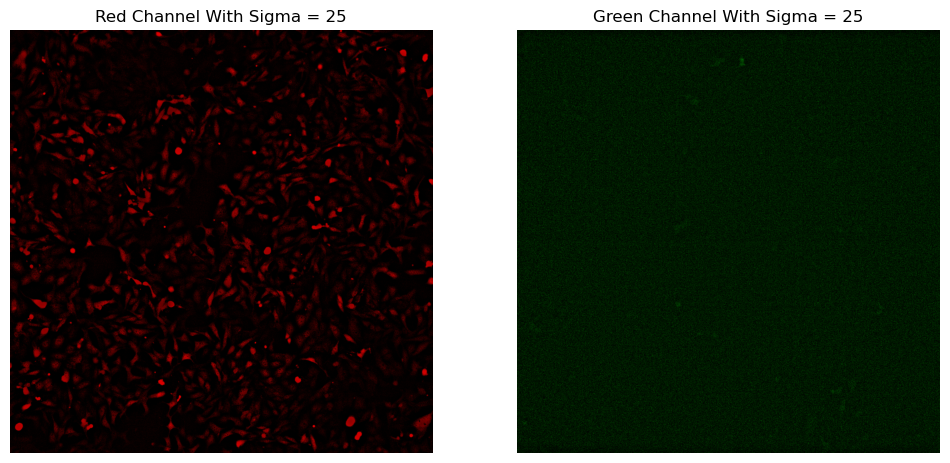

In [43]:
# Assuming red_only_image and green_only_image are already loaded and prepared:
display_subtracted_images(25)


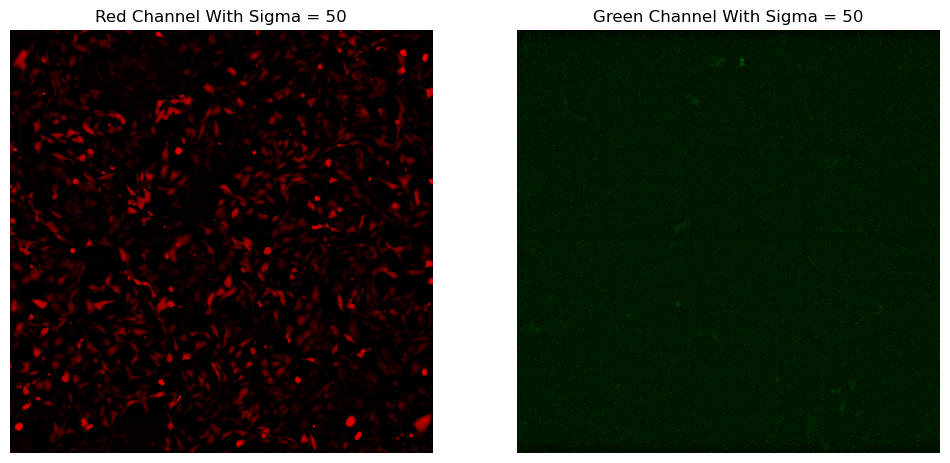

In [44]:
display_subtracted_images(50)

**Percentile Normalization:**

In [14]:

def process_image(image, channel_index, sigma, lower_percentile=2, upper_percentile=98):
    """
    Process an image: subtract background, apply percentile normalization to the specified channel,
    and maintain the RGB context, then convert to 8-bit.

    Parameters:
    - image (numpy.ndarray): Input RGB image array.
    - channel_index (int): Index of the channel to process.
    - sigma (float): Standard deviation for Gaussian blur.
    - lower_percentile (int): Lower percentile for contrast stretching.
    - upper_percentile (int): Upper percentile for contrast stretching.

    Returns:
    - numpy.ndarray: The processed 8-bit RGB image.
    """
    # Apply Gaussian blur to estimate the background of the specified channel
    background = gaussian(image[:, :, channel_index], sigma=sigma)

    # Subtract the background from the specified channel
    channel_subtracted = image[:, :, channel_index] - background

    # Clip values to ensure no negative values
    channel_subtracted = np.clip(channel_subtracted, 0, None)

    # Calculate the percentiles and apply percentile normalization
    if np.max(channel_subtracted) > 0:  # Ensure there is data to normalize
        low, high = np.percentile(channel_subtracted, [lower_percentile, upper_percentile])
        channel_normalized = np.clip((channel_subtracted - low) / (high - low), 0, 1)
    else:
        channel_normalized = np.zeros_like(channel_subtracted)  # Handle case where max is zero

    # Prepare the full RGB image with the processed channel
    processed_image = np.zeros_like(image, dtype=float)
    processed_image[:, :, channel_index] = channel_normalized  # Assign the processed channel back

    # Convert to 8-bit image for display/saving
    return img_as_ubyte(processed_image)


# display_subtracted_images(25)


TypeError: Invalid shape (2160, 2160, 3, 3) for image data

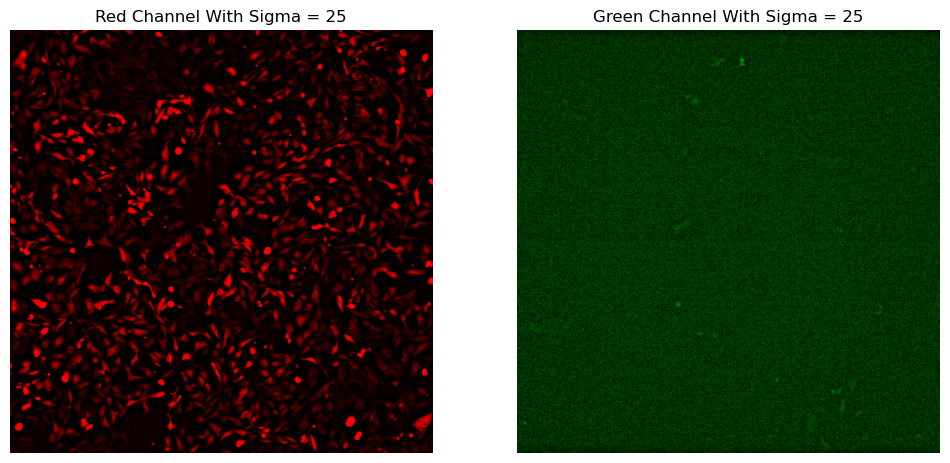

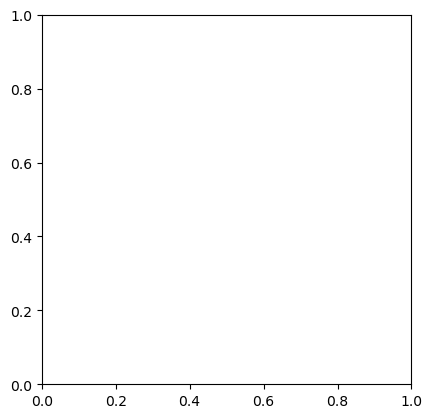

In [31]:

def display_subtracted_images(sigma):
    red_subtracted = process_image(red_only_image, 0, sigma)
    green_subtracted = process_image(green_only_image, 1, sigma)
    img_blue = np.zeros_like(red_subtracted)
    rgb_image = np.stack([red_subtracted, green_subtracted, img_blue], axis=-1)

    
    plt.figure()
    plt.imshow(rgb_image)
    plt.title('Composite')

    plt.show()
    
    # return red_subtracted, green_subtracted

display_subtracted_images(25)

In [27]:
def process_channel(image, sigma, lower_percentile=2, upper_percentile=98):
    # Apply Gaussian blur to estimate the background
    background = gaussian(image, sigma=sigma)

    # Subtract the background
    channel_subtracted = image - background

    # Clip values to ensure no negative values
    channel_subtracted = np.clip(channel_subtracted, 0, None)

    # Normalize the subtracted channel to the specified percentiles
    if np.any(channel_subtracted):  # Check if there's any non-zero value
        low, high = np.percentile(channel_subtracted, [lower_percentile, upper_percentile])
        channel_normalized = (channel_subtracted - low) / (high - low)
        channel_normalized = np.clip(channel_normalized, 0, 1)
    else:
        channel_normalized = np.zeros_like(channel_subtracted)

    # Convert to 8-bit image for display/saving
    return img_as_ubyte(channel_normalized)

def display_subtracted_images(sigma, red_image=red_only_image, green_image=green_only_image):
    # Process each channel
    red_subtracted = process_channel(red_image[0], sigma)
    green_subtracted = process_channel(green_image[1], sigma)

    # Stack into an RGB image
    img_blue = np.zeros_like(red_subtracted)
    rgb_image = np.stack([red_subtracted, green_subtracted, img_blue], axis=-1)

    # Plotting
    plt.figure(figsize=(12, 6))

    # Red Channel
    plt.subplot(1, 3, 1)
    plt.imshow(red_subtracted, cmap='Reds')
    plt.title('Red Channel')
    plt.axis('off')

    # Green Channel
    plt.subplot(1, 3, 2)
    plt.imshow(green_subtracted, cmap='Greens')
    plt.title('Green Channel')
    plt.axis('off')

    # Composite
    plt.subplot(1, 3, 3)
    plt.imshow(rgb_image)
    plt.title('Composite Image')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return red_subtracted, green_subtracted


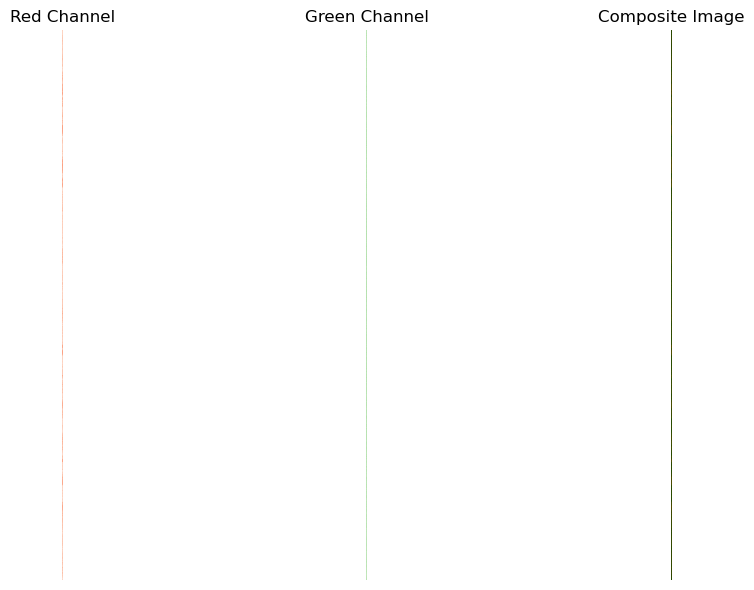

(array([[147,   0,   0],
        [141,   0,   0],
        [125,   0,   0],
        ...,
        [155,   0,   0],
        [ 89,   0,   0],
        [151,   0,   0]], dtype=uint8),
 array([[  0, 225,   0],
        [  0, 208,   0],
        [  0, 253,   0],
        ...,
        [  0, 240,   0],
        [  0, 242,   0],
        [  0, 206,   0]], dtype=uint8))

In [28]:
display_subtracted_images(50)


In [26]:
red_only_image.shape

(2160, 2160, 3)

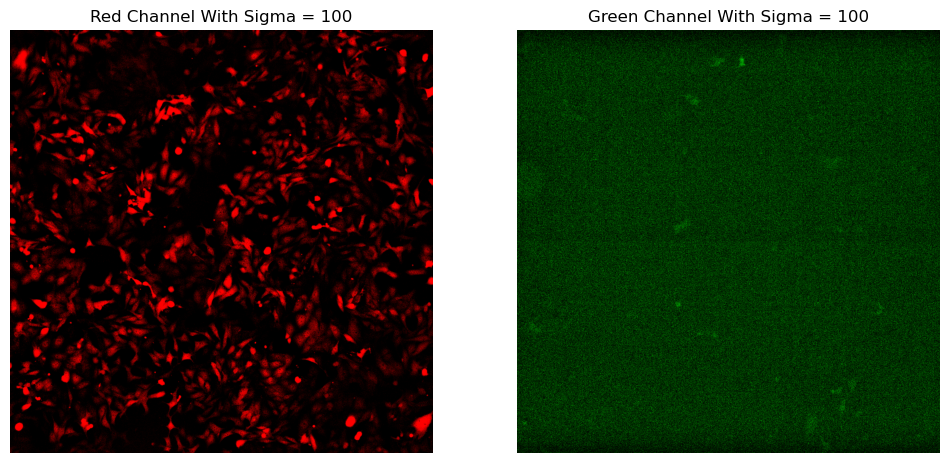

In [15]:
display_subtracted_images(100)


MetaXpress: Cam april 11th, folder same name 

**Scratch**